In [37]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
#from scipy.ndimage import gaussian_filter1d
import sys

In [38]:
date = '20220613'
dataNo = 5
scanNo = 6

In [39]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [40]:
param_name ='A0047: Lattice amp. modulation freq.'
scan_param =scan_data[param_name]
unique_param = scan_param.unique()
sample1 = unique_param[0]
sample2 = unique_param[10]
sample3 = unique_param[17]
unit = '[Hz]'
# flcount = scan_data['Total count1 @ ROI1 (arb. u.)']

In [41]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print('No images')

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

img_trans_sample1 = []
img_trans_sample2 = []
img_trans_sample3 = []
for N in range(len(trans_files)):
    if scan_param[N] == sample1:
        img_trans_sample1 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample2:
        img_trans_sample2 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample3:
        img_trans_sample3 += [np.array(Image.open(trans_files[N]))]
img_trans_sample1 = np.average(img_trans_sample1,axis=0) -img_flat_ave
img_trans_sample2 = np.average(img_trans_sample2,axis=0) -img_flat_ave
img_trans_sample3 = np.average(img_trans_sample3,axis=0) -img_flat_ave

Text(0.5, 1.0, '20000.0[Hz]')

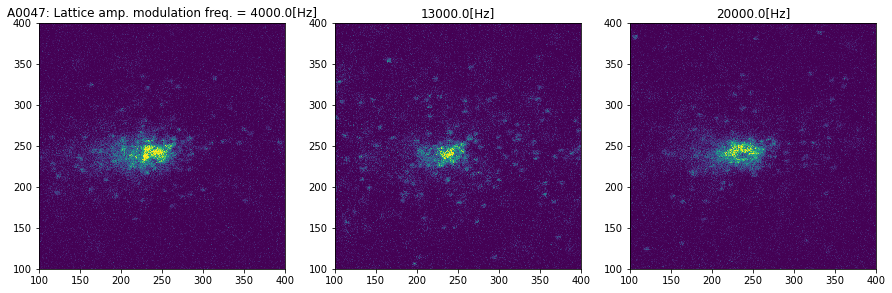

In [42]:
vmin = 0
vmax = 2000
xlim_1 = 100
xlim_2 = 400
ylim_1 = 100
ylim_2 = 400

fig =plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_sample1, vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title(param_name+ " = %.01f"%(sample1)+unit)

ax2 = fig.add_subplot(2,3,2)
mappable =ax2.pcolormesh(img_trans_sample2, vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)
ax2.set_title("%.01f"%(sample2)+unit)

ax3 = fig.add_subplot(2,3,3)
mappable =ax3.pcolormesh(img_trans_sample3, vmin=vmin, vmax=vmax, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(xlim_1,xlim_2)
ax3.set_ylim(ylim_1,ylim_2)
ax3.set_title("%.01f"%(sample3)+unit)

In [43]:
cx = 250
cy = 240
wx = 20
wy = 10
x0 = cx-wx; x1 = cx+wx
y0 = cy-wy; y1 = cy+wy

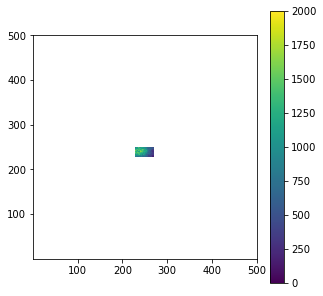

In [44]:
x=np.arange(x0,x1)
y=np.arange(y0,y1)
xmesh, ymesh = np.meshgrid(x,y)

fig =plt.figure(figsize=[5,5])
ax = fig.add_subplot(1,1,1)
mappable =ax.pcolormesh(xmesh,ymesh,img_trans_ave[y0:y1,x0:x1], vmin=vmin, vmax=vmax, shading='auto')
ax.set_aspect('equal')
ax.set_xlim(1,500)
ax.set_ylim(1,500)
fig.colorbar(mappable)

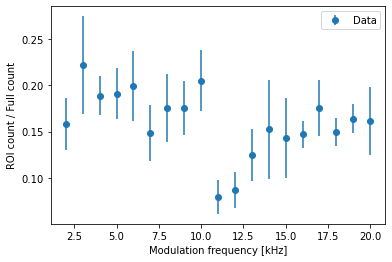

In [45]:
img_trans_list =[]
for N in range(len(trans_files)):
    img_trans_temp = [np.array(Image.open(trans_files[N])) -img_flat_ave  ]
    img_trans_list +=[np.sum(img_trans_temp[0][y0:y1,x0:x1])/np.sum(img_trans_temp)]


unique_param = scan_param.unique()
od_list = []
od_err_list = []
for i in range(len(unique_param)):
    od_temp = []
    od_err_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            od_temp.append(img_trans_list[j])
    od_list.append(np.mean(od_temp))
    od_err_list.append(np.std(od_temp))

fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(1,1,1)
ax.errorbar(unique_param*1e-3,od_list,od_err_list,fmt='o',label="Data")
ax.set_xlabel('Modulation frequency [kHz]')
ax.set_ylabel('ROI count / Full count')
ax.legend()
# plt.scatter(scan_param*1.0e-3,img_trans_list, label='Data',c="r")
# plt.xlabel('Modulation frequency [kHz]')
# plt.ylabel('ROI count / Full count')

a1= -0.10376252575193051
b1= 11778.17445387863
c1= -1728.7215887541417


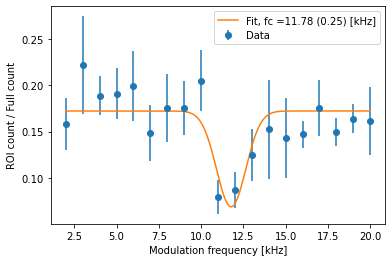

In [46]:
para_ini=[-0.01, 12000, 5000,0.07]
# modfreq=modfreq[0:len(modfreq)-1]
def nonlinear_fit(x,a1,b1,c1,d):
    return a1*np.exp(-2*(x-b1)**2/c1**2)+d

# param, cov=scipy.optimize.curve_fit(nonlinear_fit,scan_param,img_trans_list,para_ini)
param, cov=scipy.optimize.curve_fit(nonlinear_fit,unique_param,od_list,para_ini)
list_x1=list(x for x in range(int(np.min(unique_param)),int(np.max(unique_param))))
list_y1=[]
for num in list_x1:
    list_y1.append(param[0]*np.exp(-2*(num-param[1])**2/param[2]**2)+param[3])

perr=np.sqrt(np.diag(cov))
print("a1=",str(param[0]))
print("b1=",str(param[1]))
print("c1=",str(param[2]))

fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(1,1,1)
ax.errorbar(unique_param*1e-3,od_list,od_err_list,fmt='o',label="Data")
ax.plot(np.array(list_x1)*1.0e-3,list_y1,label='Fit, fc =%.02f (%.02f) [kHz]'%(param[1]*1.0e-3,perr[1]*1.0e-3))
ax.set_xlabel('Modulation frequency [kHz]')
ax.set_ylabel('ROI count / Full count')
ax.legend()